In [1]:
import numpy as np
import pandas as pd
import os
import sys

#visualization
import matplotlib.pyplot as plt
!pip install seaborn --upgrade
import seaborn as sns

#learning algorithm
import sklearn
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras.models import Sequential
from keras.layers import *
from keras.layers.wrappers import *
from keras.optimizers import RMSprop
from keras.callbacks import CSVLogger, EarlyStopping
from fbprophet import Prophet

#data preprocessing
from sklearn.preprocessing import StandardScaler


#model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 285 kB 420 kB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import AutoReg

In [3]:
train = pd.read_csv('../input/traindata/train.csv')

In [4]:
testsets = pd.read_csv('../input/testdata/0.csv')
for i in range(1,81):
    df = pd.read_csv('../input/testdata/{}.csv'.format(i))
    testsets = pd.concat([testsets,df], axis=0)
testsets = testsets.reset_index().drop('index',axis = 1)

## EDA

Text(0.5, 1.0, 'TARGET')

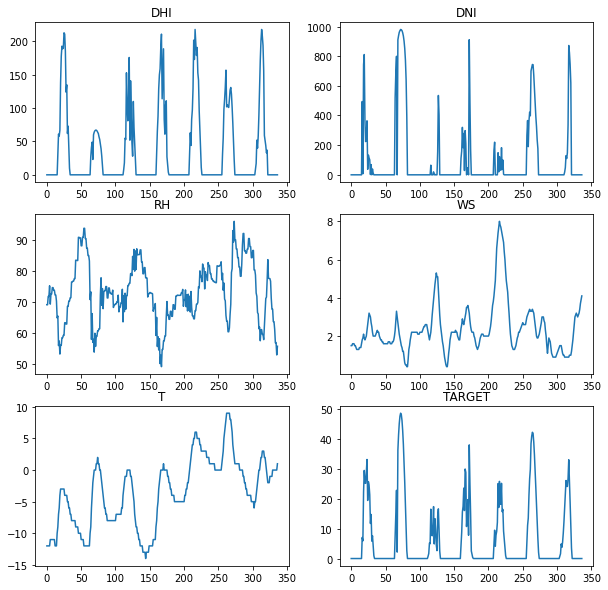

In [5]:
fig = plt.figure(figsize = (10, 10))
plt.subplot(3,2,1)
train.loc[0:336, 'DHI'].plot()
plt.title('DHI')
plt.subplot(3,2,2)
train.loc[0:336, 'DNI'].plot()
plt.title('DNI')
plt.subplot(3,2,3)
train.loc[0:336, 'RH'].plot()
plt.title('RH')
plt.subplot(3,2,4)
train.loc[0:336, 'WS'].plot()
plt.title('WS')
plt.subplot(3,2,5)
train.loc[0:336, 'T'].plot()
plt.title('T')
plt.subplot(3,2,6)
train.loc[0:336, 'TARGET'].plot()
plt.title('TARGET')

### autocorrelation check

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


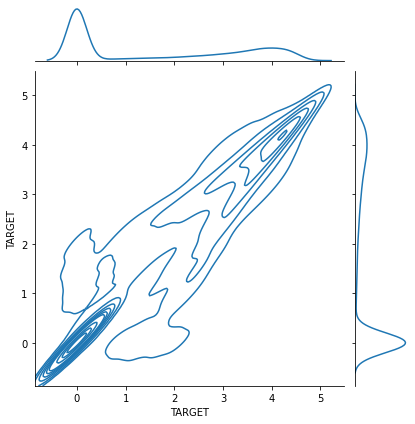

In [6]:
sns.jointplot(np.log(train['TARGET']+1), np.log(train['TARGET'].shift(1)+1), kind = 'kde')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


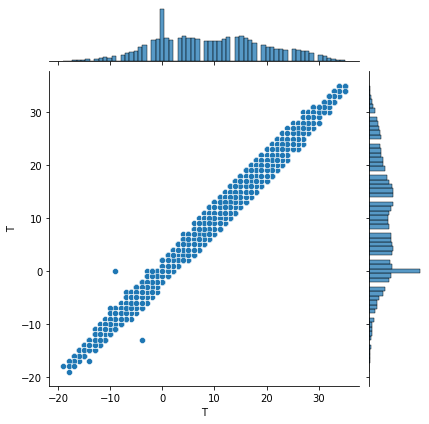

In [7]:
sns.jointplot(train['T'], train['T'].shift(1), kind = 'scatter')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


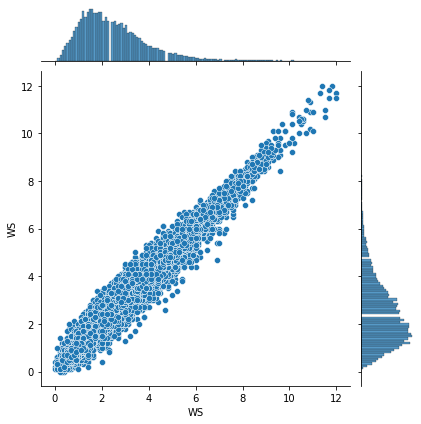

In [8]:
sns.jointplot(train['WS'], train['WS'].shift(1), kind = 'scatter')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


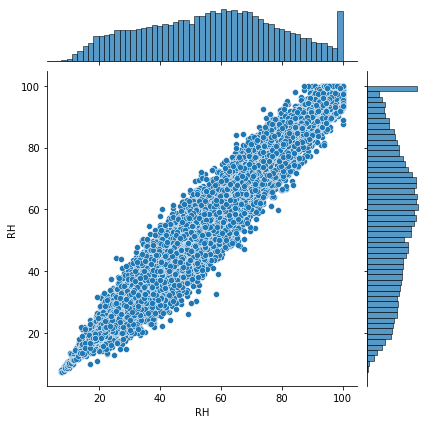

In [9]:
sns.jointplot(train['RH'], train['RH'].shift(1), kind = 'scatter')

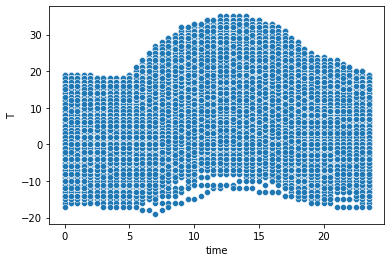

In [10]:
#time ~ TARGET
train['time'] = train['Hour']+train['Minute']/60
sns.scatterplot(data = train, x = 'time', y = 'T')

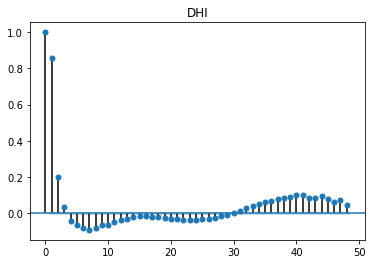

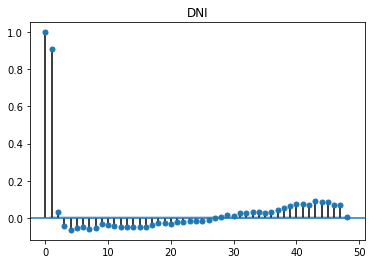

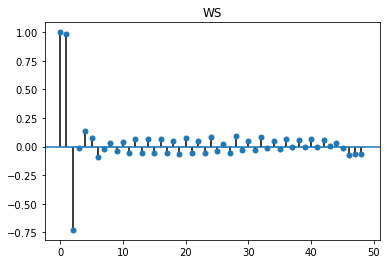

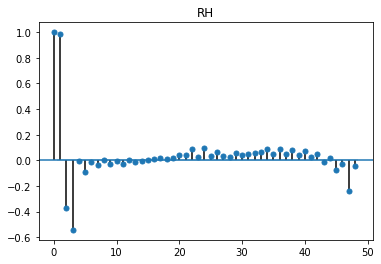

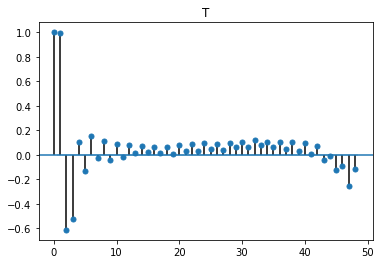

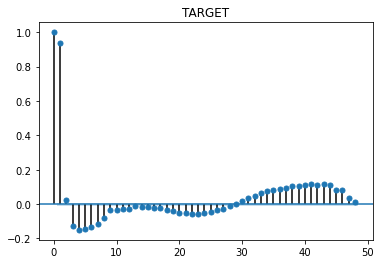

In [11]:
for col in ['DHI','DNI', 'WS', 'RH', 'T', 'TARGET']:
    plot_pacf(train[col])
    plt.title(col)

* TARGET 은 lag 1 까지 편상관이 큼
* DHI는 lag 1 까지 편상관이 큼
* DNI는 lag 1 까지 편상관이 큼
* WS는 lag 2 까지 편상관이 큼
* RH는 lag 3 까지 편상관이 큼
* T 는 lag 3 까지 편상관이 큼

In [12]:
train['time'] = train['Hour']+train['Minute']/60

## MODEL1. univariate multistep linear model
7일간의 TARGET 값을 통해 next 2일간의 TARGET 값을 도출하는 선형 모델

In [13]:
train_uni_linear = train.drop(['Day', 'Hour', 'Minute'], axis = 1)

In [14]:
trainset, valset = train_test_split(train_uni_linear, test_size = 100/1095, shuffle = False)

In [15]:
def to_supervised_dnn_univariate_multistep(train, input_ts, output_ts, feature):
    X_train = np.zeros((len(train)-input_ts-output_ts, input_ts, 1))
    y_train = np.zeros((len(train)-input_ts-output_ts, output_ts))
    for idx in range(len(train)-input_ts-output_ts):
        train_idx = idx
        target_idx = idx + input_ts
        X_obs = train.iloc[train_idx:target_idx, :][feature]
        target = train.iloc[target_idx:target_idx+output_ts, :][feature]
        
        X_train[idx,:,:] = X_obs.values.reshape(input_ts, 1)
        y_train[idx,:] = target.values
    return X_train, y_train



In [16]:
X_train_TARGET, y_train_TARGET = to_supervised_dnn_univariate_multistep(trainset, 336, 96, 'TARGET')
X_val_TARGET, y_val_TARGET = to_supervised_dnn_univariate_multistep(valset, 336, 96, 'TARGET')

In [17]:
#model 생성 함수
def build_univariate_linear_model(quantile):
    model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [336, 1]),
    keras.layers.Dense(96) #TARGET feature는 0보다 크거나 같으므
    ])
    optimizer_adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss=tfa.losses.PinballLoss(tau=quantile),
                             optimizer=optimizer_adam,
                             metrics = tfa.losses.PinballLoss(tau=quantile))
    return model

In [18]:
uni_linear_1 = build_univariate_linear_model(0.1)
uni_linear_2 = build_univariate_linear_model(0.2)
uni_linear_3 = build_univariate_linear_model(0.3)
uni_linear_4 = build_univariate_linear_model(0.4)
uni_linear_5 = build_univariate_linear_model(0.5)
uni_linear_6 = build_univariate_linear_model(0.6)
uni_linear_7 = build_univariate_linear_model(0.7)
uni_linear_8 = build_univariate_linear_model(0.8)
uni_linear_9 = build_univariate_linear_model(0.9)

In [19]:
#9개의 모델에 대한 training
checkpoint_cb = keras.callbacks.ModelCheckpoint('uni_linear_1.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
uni_linear_history_1 = uni_linear_1.fit(X_train_TARGET, y_train_TARGET,
                              validation_data=(X_val_TARGET, y_val_TARGET), 
                              epochs=40, verbose=1,
                              callbacks=[earlystopping_cb, checkpoint_cb])

checkpoint_cb = keras.callbacks.ModelCheckpoint('uni_linear_2.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
uni_linear_history_2 = uni_linear_2.fit(X_train_TARGET, y_train_TARGET,
                              validation_data=(X_val_TARGET, y_val_TARGET), 
                              epochs=40, verbose=1,
                              callbacks=[earlystopping_cb, checkpoint_cb])

checkpoint_cb = keras.callbacks.ModelCheckpoint('uni_linear_3.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
uni_linear_history_3 = uni_linear_3.fit(X_train_TARGET, y_train_TARGET,
                              validation_data=(X_val_TARGET, y_val_TARGET), 
                              epochs=40, verbose=1,
                              callbacks=[earlystopping_cb, checkpoint_cb])

checkpoint_cb = keras.callbacks.ModelCheckpoint('uni_linear_4.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
uni_linear_history_4 = uni_linear_4.fit(X_train_TARGET, y_train_TARGET,
                              validation_data=(X_val_TARGET, y_val_TARGET), 
                              epochs=40, verbose=1,
                              callbacks=[earlystopping_cb, checkpoint_cb])

checkpoint_cb = keras.callbacks.ModelCheckpoint('uni_linear_5.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
uni_linear_history_5 = uni_linear_5.fit(X_train_TARGET, y_train_TARGET,
                              validation_data=(X_val_TARGET, y_val_TARGET), 
                              epochs=40, verbose=1,
                              callbacks=[earlystopping_cb, checkpoint_cb])

checkpoint_cb = keras.callbacks.ModelCheckpoint('uni_linear_6.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
uni_linear_history_6 = uni_linear_6.fit(X_train_TARGET, y_train_TARGET,
                              validation_data=(X_val_TARGET, y_val_TARGET), 
                              epochs=40, verbose=1,
                              callbacks=[earlystopping_cb, checkpoint_cb])

checkpoint_cb = keras.callbacks.ModelCheckpoint('uni_linear_7.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
uni_linear_history_7 = uni_linear_7.fit(X_train_TARGET, y_train_TARGET,
                              validation_data=(X_val_TARGET, y_val_TARGET), 
                              epochs=40, verbose=1,
                              callbacks=[earlystopping_cb, checkpoint_cb])

checkpoint_cb = keras.callbacks.ModelCheckpoint('uni_linear_8.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
uni_linear_history_8 = uni_linear_8.fit(X_train_TARGET, y_train_TARGET,
                              validation_data=(X_val_TARGET, y_val_TARGET), 
                              epochs=40, verbose=1,
                              callbacks=[earlystopping_cb, checkpoint_cb])

checkpoint_cb = keras.callbacks.ModelCheckpoint('uni_linear_9.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
uni_linear_history_9 = uni_linear_9.fit(X_train_TARGET, y_train_TARGET,
                              validation_data=(X_val_TARGET, y_val_TARGET), 
                              epochs=40, verbose=1,
                              callbacks=[earlystopping_cb, checkpoint_cb])

Epoch 1/40
1479/1479 [==============================] - 2s 2ms/step - loss: 2.3513 - pinball_loss: 2.3513 - val_loss: 1.2464 - val_pinball_loss: 1.2450
Epoch 2/40
1479/1479 [==============================] - 2s 1ms/step - loss: 1.8613 - pinball_loss: 1.8613 - val_loss: 1.1364 - val_pinball_loss: 1.1354
Epoch 3/40
1479/1479 [==============================] - 2s 1ms/step - loss: 1.7221 - pinball_loss: 1.7221 - val_loss: 1.0908 - val_pinball_loss: 1.0898
Epoch 4/40
1479/1479 [==============================] - 2s 1ms/step - loss: 1.6790 - pinball_loss: 1.6790 - val_loss: 1.1067 - val_pinball_loss: 1.1057
Epoch 5/40
1479/1479 [==============================] - 2s 1ms/step - loss: 1.6674 - pinball_loss: 1.6674 - val_loss: 1.0797 - val_pinball_loss: 1.0785
Epoch 6/40
1479/1479 [==============================] - 2s 1ms/step - loss: 1.6629 - pinball_loss: 1.6629 - val_loss: 1.1003 - val_pinball_loss: 1.0991
Epoch 7/40
1479/1479 [==============================] - 2s 1ms/step - loss: 1.6612 - pin

In [20]:
#load trained model
uni_linear_1 = keras.models.load_model('../input/uni-linear-models/uni_linear_1.h5')
uni_linear_2 = keras.models.load_model('../input/uni-linear-models/uni_linear_2.h5')
uni_linear_3 = keras.models.load_model('../input/uni-linear-models/uni_linear_3.h5')
uni_linear_4 = keras.models.load_model('../input/uni-linear-models/uni_linear_4.h5')
uni_linear_5 = keras.models.load_model('../input/uni-linear-models/uni_linear_5.h5')
uni_linear_6 = keras.models.load_model('../input/uni-linear-models/uni_linear_6.h5')
uni_linear_7 = keras.models.load_model('../input/uni-linear-models/uni_linear_7.h5')
uni_linear_8 = keras.models.load_model('../input/uni-linear-models/uni_linear_8.h5')
uni_linear_9 = keras.models.load_model('../input/uni-linear-models/uni_linear_9.h5')

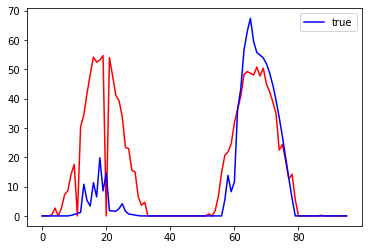

In [21]:
#validation data visualization
pred_1 = uni_linear_1.predict(X_val_TARGET[100].reshape(1,336,1)).reshape(96)
pred_2 = uni_linear_2.predict(X_val_TARGET[100].reshape(1,336,1)).reshape(96)
pred_3 = uni_linear_3.predict(X_val_TARGET[100].reshape(1,336,1)).reshape(96)
pred_4 = uni_linear_4.predict(X_val_TARGET[100].reshape(1,336,1)).reshape(96)
pred_5 = uni_linear_5.predict(X_val_TARGET[100].reshape(1,336,1)).reshape(96)
pred_6 = uni_linear_6.predict(X_val_TARGET[100].reshape(1,336,1)).reshape(96)
pred_7 = uni_linear_7.predict(X_val_TARGET[100].reshape(1,336,1)).reshape(96)
pred_8 = uni_linear_8.predict(X_val_TARGET[100].reshape(1,336,1)).reshape(96)
pred_9 = uni_linear_9.predict(X_val_TARGET[100].reshape(1,336,1)).reshape(96)
y_val = y_val_TARGET[100]

fig = plt.figure()
plt.plot(pred_9, c = 'red')
plt.plot(y_val, c = 'blue', label = 'true')
plt.legend()

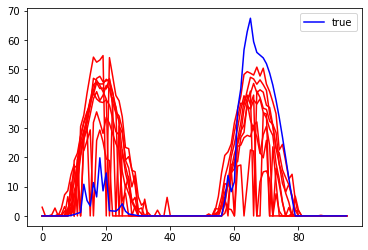

In [22]:
fig = plt.figure()
plt.plot(pred_1, c = 'red')
plt.plot(pred_2, c = 'red')
plt.plot(pred_3, c = 'red')
plt.plot(pred_4, c = 'red')
plt.plot(pred_5, c = 'red')
plt.plot(pred_6, c = 'red')
plt.plot(pred_7, c = 'red')
plt.plot(pred_8, c = 'red')
plt.plot(pred_9, c = 'red')
plt.plot(y_val, c = 'blue', label = 'true')
plt.legend()

In [23]:
#test data의 last day의 timestep에서 해가 진 시간을 기준으로 pred의 예측값을 0으로 바꾸어주는 함수
def process_night(X_test, pred): #pred는 1d array, X_test는 3d tensor(1,336,1)
    X_test = X_test.reshape(336)
    target_lastday = X_test[-49:-1].reshape(48) #X_test를 1D array로 바꾸어주기
    night_idx = np.where(target_lastday ==0) #해가 진 시점의 idx
    day_idx = np.where(target_lastday > 0)
    
    pred[night_idx] = 0
    pred[night_idx + 48] = 0
    
    return pred, before_sunrise, after_sunset

def final_prediction_model(model, X_test): #input으로 모델과 X_test(length of 336 3d tensor) 받음
    pred = model.predict(X_test)
    pred = pred.reshape(96) #prediction 후 1d array로 reshape
    
    X_test_TARGET = X_test.reshape(336)
    target_lastday = X_test_TARGET[-49:-1].reshape(48) #X_test를 1D array로 바꾸어주기
    night_idx = np.where(target_lastday ==0) #해가 진 시점의 idx
    day_idx = np.where(target_lastday > 0) #해가 떠 있는 시점의 idx
    pred[night_idx] = 0
    pred[night_idx + 48] = 0  #prediction modification
    
    for i in range(1,95):
        if ((i >= before_sunrise+2)&(i <= after_sunset)) | ((i >= before_sunrise+2+48)&(i <= after_sunset+48)):
            pred[i] = (pred[i-1]+pred[i+1]) / 2 #낮 시간대에 일사량이 0으로 나올 경우 직전ts와 직후ts의 평균값으로 대체

    return pred

In [24]:
def final_prediction_model(model, X_test): #input으로 모델과 X_test(length of 336 3d tensor) 받음
    pred = model.predict(X_test) #pred는 2d tensor
    pred = pred.reshape(96) #prediction 후 1d array로 reshape
    
    X_test_TARGET = X_test.reshape(336)
    target_lastday = X_test_TARGET[-49:-1].reshape(48) #X_test를 1D array로 바꾸어주기
    night_idx = np.where(target_lastday ==0) #해가 진 시점의 idx
    day_idx = np.where(target_lastday > 0) #해가 떠 있는 시점의 idx
    
    pred[night_idx] = 0
    pred[np.array(night_idx)+48] = 0  #prediction modification
    
    for i in range(1,95):
        if ((i in np.array(day_idx))|(i in np.array(day_idx)+48))&(pred[i]==0):
            pred[i] = pred[i-1]/2 + pred[i+1]/2
    return pred

In [25]:
#baseline prediction
sub = pd.read_csv('../input/sample-sub/sample_submission.csv')
for index in range(81):
    testsample = testsets['TARGET'].values[(336*index):(336*(index+1))].reshape(1,336,1)
    sub.loc[(96*index):(96*(index+1)-1), 'q_0.1'] = final_prediction_model(uni_linear_1,testsample)
    sub.loc[(96*index):(96*(index+1)-1), 'q_0.2'] = final_prediction_model(uni_linear_2,testsample)
    sub.loc[(96*index):(96*(index+1)-1), 'q_0.3'] = final_prediction_model(uni_linear_3,testsample)
    sub.loc[(96*index):(96*(index+1)-1), 'q_0.4'] = final_prediction_model(uni_linear_4,testsample)
    sub.loc[(96*index):(96*(index+1)-1), 'q_0.5'] = final_prediction_model(uni_linear_5,testsample)
    sub.loc[(96*index):(96*(index+1)-1), 'q_0.6'] = final_prediction_model(uni_linear_6,testsample)
    sub.loc[(96*index):(96*(index+1)-1), 'q_0.7'] = final_prediction_model(uni_linear_7,testsample)
    sub.loc[(96*index):(96*(index+1)-1), 'q_0.8'] = final_prediction_model(uni_linear_8,testsample)
    sub.loc[(96*index):(96*(index+1)-1), 'q_0.9'] = final_prediction_model(uni_linear_9,testsample)

In [26]:
sub.to_csv('uni_linear_model_submission.csv')

## Model 2. Multivariate multistep linear model 

In [27]:
train_mul_linear = train.drop(['Day', 'Hour', 'Minute'], axis = 1)
trainset, valset = train_test_split(train_mul_linear, test_size = 100/1095, shuffle = False)

train_mean = train_mul_linear.mean(axis = 0)
train_std = train_mul_linear.std(axis = 0)

In [28]:
def to_supervised_dnn_multivariate_multistep(train, input_ts, output_ts, feature, train_mean, train_std):
    X_train = np.zeros((len(train)-input_ts-output_ts, input_ts, train.shape[1]))
    y_train = np.zeros((len(train)-input_ts-output_ts, output_ts))
    train_input = (train - train_mean) / train_std
    train_output = train.copy()
    for idx in range(len(train)-input_ts-output_ts):
        train_idx = idx
        target_idx = idx + input_ts
        X_obs = train_input.iloc[train_idx:target_idx, :]
        target = train_output.iloc[target_idx:target_idx+output_ts, :][feature]
        
        X_train[idx,:,:] = X_obs.values.reshape(input_ts, train.shape[1])
        y_train[idx,:] = target.values
    return X_train, y_train

In [29]:
X_train_mul, y_train_mul = to_supervised_dnn_multivariate_multistep(trainset, 336, 96, 'TARGET', train_mean, train_std)
X_val_mul, y_val_mul = to_supervised_dnn_multivariate_multistep(valset,336, 96, 'TARGET', train_mean, train_std)

In [30]:
def build_multivariate_linear_model(quantile):
    model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [336, 7]),
    keras.layers.Dense(96, activation = 'relu') #TARGET feature는 0보다 크거나 같으므
    ])
    optimizer_adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss=tfa.losses.PinballLoss(tau=quantile),
                             optimizer=optimizer_adam,
                             metrics = tfa.losses.PinballLoss(tau=quantile))
    return model


In [31]:
mul_linear_1 = build_multivariate_linear_model(0.1)
mul_linear_2 = build_multivariate_linear_model(0.2)
mul_linear_3 = build_multivariate_linear_model(0.3)
mul_linear_4 = build_multivariate_linear_model(0.4)
mul_linear_5 = build_multivariate_linear_model(0.5)
mul_linear_6 = build_multivariate_linear_model(0.6)
mul_linear_7 = build_multivariate_linear_model(0.7)
mul_linear_8 = build_multivariate_linear_model(0.8)
mul_linear_9 = build_multivariate_linear_model(0.9)
mul_linear_1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 96)                225888    
Total params: 225,888
Trainable params: 225,888
Non-trainable params: 0
_________________________________________________________________


In [32]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('mul_linear_1.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mul_linear_history_1 = mul_linear_1.fit(X_train_mul, y_train_mul,
                              validation_data=(X_val_mul, y_val_mul), 
                              epochs=40, verbose=1,
                              callbacks=[earlystopping_cb, checkpoint_cb])

checkpoint_cb = keras.callbacks.ModelCheckpoint('mul_linear_2.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mul_linear_history_2 = mul_linear_2.fit(X_train_mul, y_train_mul,
                              validation_data=(X_val_mul, y_val_mul), 
                              epochs=40, verbose=1,
                              callbacks=[earlystopping_cb, checkpoint_cb])

checkpoint_cb = keras.callbacks.ModelCheckpoint('mul_linear_3.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mul_linear_history_3 = mul_linear_3.fit(X_train_mul, y_train_mul,
                              validation_data=(X_val_mul, y_val_mul), 
                              epochs=40, verbose=1,
                              callbacks=[earlystopping_cb, checkpoint_cb])

checkpoint_cb = keras.callbacks.ModelCheckpoint('mul_linear_4.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mul_linear_history_4 = mul_linear_4.fit(X_train_mul, y_train_mul,
                              validation_data=(X_val_mul, y_val_mul), 
                              epochs=40, verbose=1,
                              callbacks=[earlystopping_cb, checkpoint_cb])

checkpoint_cb = keras.callbacks.ModelCheckpoint('mul_linear_5.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mul_linear_history_5 = mul_linear_5.fit(X_train_mul, y_train_mul,
                              validation_data=(X_val_mul, y_val_mul), 
                              epochs=40, verbose=1,
                              callbacks=[earlystopping_cb, checkpoint_cb])

checkpoint_cb = keras.callbacks.ModelCheckpoint('mul_linear_6.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mul_linear_history_6 = mul_linear_6.fit(X_train_mul, y_train_mul,
                              validation_data=(X_val_mul, y_val_mul), 
                              epochs=40, verbose=1,
                              callbacks=[earlystopping_cb, checkpoint_cb])

checkpoint_cb = keras.callbacks.ModelCheckpoint('mul_linear_7.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mul_linear_history_7 = mul_linear_7.fit(X_train_mul, y_train_mul,
                              validation_data=(X_val_mul, y_val_mul), 
                              epochs=40, verbose=1,
                              callbacks=[earlystopping_cb, checkpoint_cb])

checkpoint_cb = keras.callbacks.ModelCheckpoint('mul_linear_8.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mul_linear_history_8 = mul_linear_8.fit(X_train_mul, y_train_mul,
                              validation_data=(X_val_mul, y_val_mul), 
                              epochs=40, verbose=1,
                              callbacks=[earlystopping_cb, checkpoint_cb])

checkpoint_cb = keras.callbacks.ModelCheckpoint('mul_linear_9.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mul_linear_history_9 = mul_linear_9.fit(X_train_mul, y_train_mul,
                              validation_data=(X_val_mul, y_val_mul), 
                              epochs=40, verbose=1,
                              callbacks=[earlystopping_cb, checkpoint_cb])

Epoch 1/40
1479/1479 [==============================] - 4s 3ms/step - loss: 1.4655 - pinball_loss: 1.4655 - val_loss: 0.9358 - val_pinball_loss: 0.9345
Epoch 2/40
1479/1479 [==============================] - 4s 3ms/step - loss: 1.4202 - pinball_loss: 1.4202 - val_loss: 0.9312 - val_pinball_loss: 0.9299
Epoch 3/40
1479/1479 [==============================] - 4s 3ms/step - loss: 1.4040 - pinball_loss: 1.4040 - val_loss: 0.9370 - val_pinball_loss: 0.9358
Epoch 4/40
1479/1479 [==============================] - 4s 3ms/step - loss: 1.3946 - pinball_loss: 1.3946 - val_loss: 0.9455 - val_pinball_loss: 0.9441
Epoch 5/40
1479/1479 [==============================] - 4s 3ms/step - loss: 1.3881 - pinball_loss: 1.3881 - val_loss: 0.9407 - val_pinball_loss: 0.9394
Epoch 6/40
1479/1479 [==============================] - 4s 2ms/step - loss: 1.3825 - pinball_loss: 1.3825 - val_loss: 0.9481 - val_pinball_loss: 0.9466
Epoch 7/40
1479/1479 [==============================] - 4s 3ms/step - loss: 1.3782 - pin

In [33]:
def final_prediction_model_mul_validation(model, X_test): #input으로 모델과 전처리 후의 X_test(length of 336 3d tensor) 받음
    pred = model.predict(X_test) #pred는 2d tensor
    pred = pred.reshape(96) #prediction 후 1d array로 reshape
    
    X_test_TARGET = X_test[:,:,-2].reshape(336)
    target_lastday = X_test_TARGET[-49:-1].reshape(48) #X_test를 1D array로 바꾸어주기
    night_idx = np.where(target_lastday ==0) #해가 진 시점의 idx
    day_idx = np.where(target_lastday > 0) #해가 떠 있는 시점의 idx
    
    pred[night_idx] = 0
    pred[np.array(night_idx)+48] = 0  #prediction modification
    
    for i in range(1,95):
        if ((i in np.array(day_idx))|(i in np.array(day_idx)+48))&(pred[i]==0):
            pred[i] = pred[i-1]/2 + pred[i+1]/2
    return pred

In [34]:
def test_prepare(testset):
    testset['time'] = testset['Hour']+testset['Minute']/60
    testset = testset.drop(['Day', 'Hour', 'Minute'], axis = 1)
    scaler = StandardScaler()
    testset = scaler.fit_transform(testset)
    
    return testset

In [35]:
def final_prediction_model_mul_submission(model, X_test): #input으로 모델과 전처리 전의 X_test(dataframe) 받음
    X_test_prep = test_prepare(X_test).reshape(1,336,7) #X_test_prep is shape of (1,336,)
    pred = model.predict(X_test_prep) #pred는 2d tensor
    pred = pred.reshape(96) #prediction 후 1d array로 reshape
    
    X_test_TARGET = X_test['TARGET'].values.reshape(336) #scaling 되지 않은 데이터프레임의 target variable
    target_lastday = X_test_TARGET[-49:-1].reshape(48) #X_test를 1D array로 바꾸어주기
    night_idx = np.where(target_lastday ==0) #해가 진 시점의 idx
    day_idx = np.where(target_lastday > 0) #해가 떠 있는 시점의 idx
    
    pred[night_idx] = 0
    pred[np.array(night_idx)+48] = 0  #prediction modification
    
    for i in range(1,95):
        if ((i in np.array(day_idx))|(i in np.array(day_idx)+48))&(pred[i]==0):
            pred[i] = pred[i-1]/2 + pred[i+1]/2
    return pred

In [36]:
for index in range(81):
    testsample = testsets[(336*index):(336*(index+1))].copy()
    sub.loc[(96*index):(96*(index+1)-1), 'q_0.1'] = final_prediction_model_mul_submission(mul_linear_1,testsample)
    sub.loc[(96*index):(96*(index+1)-1), 'q_0.2'] = final_prediction_model_mul_submission(mul_linear_2,testsample)
    sub.loc[(96*index):(96*(index+1)-1), 'q_0.3'] = final_prediction_model_mul_submission(mul_linear_3,testsample)
    sub.loc[(96*index):(96*(index+1)-1), 'q_0.4'] = final_prediction_model_mul_submission(mul_linear_4,testsample)
    sub.loc[(96*index):(96*(index+1)-1), 'q_0.5'] = final_prediction_model_mul_submission(mul_linear_5,testsample)
    sub.loc[(96*index):(96*(index+1)-1), 'q_0.6'] = final_prediction_model_mul_submission(mul_linear_6,testsample)
    sub.loc[(96*index):(96*(index+1)-1), 'q_0.7'] = final_prediction_model_mul_submission(mul_linear_7,testsample)
    sub.loc[(96*index):(96*(index+1)-1), 'q_0.8'] = final_prediction_model_mul_submission(mul_linear_8,testsample)
    sub.loc[(96*index):(96*(index+1)-1), 'q_0.9'] = final_prediction_model_mul_submission(mul_linear_9,testsample)
    
sub.to_csv('mul_linear_submission.csv')

In [37]:
3024 / 336

9.0

### RNN model

In [38]:
train_prep = train.drop(['Day', 'TARGET'], axis =1)
trainset, valset = train_test_split(train_prep, test_size = 995/1095, shuffle = False)

In [39]:
def to_supervised_rnn(train, input_ts, output_ts, feature):
    X_train = np.zeros((len(train)-input_ts-output_ts, input_ts, train.shape[1]))
    y_train = np.zeros((len(train)-input_ts-output_ts, output_ts))
    for idx in range(len(train)-input_ts-output_ts):
        train_idx = idx
        target_idx = idx + input_ts
        X_obs = train.iloc[train_idx:target_idx, :]
        target = train.iloc[target_idx:target_idx+output_ts, :][feature]
        
        X_train[idx,:,:] = X_obs.values
        y_train[idx,:] = target.values
    return X_train, y_train

In [40]:
X_train, y_train_DHI = to_supervised_rnn(trainset, 336, 96, 'DHI')
X_val, y_val_DHI = to_supervised_rnn(valset, 336, 96, 'DHI')

X_train, y_train_DNI = to_supervised_rnn(trainset, 336, 96, 'DNI')
X_val, y_val_DNI = to_supervised_rnn(valset, 336, 96, 'DNI')

X_train, y_train_RH = to_supervised_rnn(trainset, 336, 96, 'RH')
X_val, y_val_RH = to_supervised_rnn(valset, 336, 96, 'RH')

X_train, y_train_WS = to_supervised_rnn(trainset, 336, 96, 'WS')
X_val, y_val_WS = to_supervised_rnn(valset, 336, 96, 'WS')

X_train, y_train_T = to_supervised_rnn(trainset, 336, 96, 'T')
X_val, y_val_T = to_supervised_rnn(valset, 336, 96, 'T')

In [41]:
model_T = Sequential()
model_T.add(LSTM(20, activation='relu', return_sequences = True, input_shape=(336, 7)))
model_T.add(LSTM(20, activation='relu', return_sequences = True))
model_T.add(TimeDistributed(Dense(96)))
model_T.compile(loss='mae', optimizer='adam')
model_T.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 336, 20)           2240      
_________________________________________________________________
lstm_1 (LSTM)                (None, 336, 20)           3280      
_________________________________________________________________
time_distributed (TimeDistri (None, 336, 96)           2016      
Total params: 7,536
Trainable params: 7,536
Non-trainable params: 0
_________________________________________________________________


In [42]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('lstm_T.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

T_history = model_T.fit(X_train, y_train_T,
                              validation_data=(X_val, y_val_T), 
                              epochs=40, verbose=1,
                              callbacks=[earlystopping_cb, checkpoint_cb])

Epoch 1/40


ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:227 assert_input_compatibility
        ', found shape=' + str(shape))

    ValueError: Input 0 is incompatible with layer sequential_18: expected shape=(None, None, 7), found shape=[None, 336, 8]
